In [81]:
import sys
sys.path.append("..") 
import numpy as np

import matplotlib.pyplot as plt 
from sgd_framework.sgd import SGD
from sgd_framework.parameter_estimator import ParameterEstimator
from sgd_framework.regression_model import RegressionModel
from data.generate_synthetic_data import transform_to_polynomial, generate_training_data_fixed
from sklearn.model_selection import train_test_split
from sgd_framework.twolayer_nn import TwoLayerNNModel
from sgd_framework.nonconvex_sgd import NonConvexSGD, FixedStepsize, DiminishingStepsize

In [82]:
np.random.seed(0)
X_raw, _, _ = generate_training_data_fixed(m=1000, n=2, noise=0.001)
X_poly = transform_to_polynomial(X_raw, degree=3, normalize=True)

true_A = 0.01 * np.arange(1, X_poly.shape[1] + 1)
true_b = 1.0
noise = 0.001
y = (X_poly @ true_A + true_b + noise * np.random.randn(X_poly.shape[0]))
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)


# PR fixed
poly_model_fixed = RegressionModel(X_train, y_train)
sgd_fixed_poly = SGD(poly_model_fixed, num_iterations=1000, batch_size=1, noise=noise, stepsize_type='fixed')
w_fixed_poly, *_ = sgd_fixed_poly.optimize()
poly_test_pred = X_test @ w_fixed_poly[1:] + w_fixed_poly[0]
poly_mse_fixed = np.mean((poly_test_pred- y_test) ** 2)


#  PR diminishing
poly_model_diminish = RegressionModel(X_train, y_train)
sgd_diminish_poly = SGD(poly_model_diminish, num_iterations=1000, batch_size=1, noise=noise, stepsize_type='diminishing')
w_diminish_poly, *_ = sgd_diminish_poly.optimize()
poly_test_pred_diminish = X_test @ w_diminish_poly[1:] + w_diminish_poly[0]
poly_mse_diminish = np.mean((poly_test_pred_diminish- y_test) ** 2)

In [83]:
alpha = sgd_fixed_poly.strategy.alpha
beta = sgd_diminish_poly.strategy.beta
gamma = sgd_diminish_poly.strategy.gamma

print(alpha)
print(beta, gamma)

0.011413631279508783
6.740571264047555 556.5121206069825


In [ ]:
# track error over iterations
# run diagnostic
hidden_sizes = [1, 5, 10, 20, 50]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_raw, y, test_size=0.3)
nn_train_mse_fixed = []
nn_test_mse_fixed = []
nn_train_mse_diminish = []
nn_test_mse_diminish = []
for h in hidden_sizes:
    print(f"Training NN with width {h} hidden layer fixed stepsize")
    nn_fixed = TwoLayerNNModel(input_dim=X_train2.shape[1], hidden_dim=h)
    fixed_type = FixedStepsize(alpha=alpha)
    sgd_fixed = NonConvexSGD(nn_fixed, X_train2, y_train2, num_iterations=1000, batch_size=1, stepsize_type=fixed_type)
    w_fixed, obj_history_fixed, norm_history_fixed = sgd_fixed.optimize()

    preds_train_fixed = np.array([nn_fixed.forward(x.flatten(), w_fixed) for x in X_train2])
    preds_test_fixed = np.array([nn_fixed.forward(x.flatten(), w_fixed) for x in X_test2])
    train_mse_fixed = np.mean((preds_train_fixed - y_train2) ** 2)
    test_mse_fixed = np.mean((preds_test_fixed - y_test2) ** 2)
    nn_train_mse_fixed.append(train_mse_fixed)
    nn_test_mse_fixed.append(test_mse_fixed)
    print(norm_history_fixed[-1])

    print(f"Training NN with width {h} hidden layer diminishing stepsize")
    nn_diminish = TwoLayerNNModel(input_dim=X_train2.shape[1], hidden_dim=h)
    diminish_type = DiminishingStepsize(beta=beta, gamma=gamma)
    sgd_diminish = NonConvexSGD(nn_diminish, X_train2, y_train2, num_iterations=1000, batch_size=1, stepsize_type=diminish_type)
    w_diminish, obj_history_diminish, norm_history_diminish = sgd_diminish.optimize()

    preds_train_diminish = np.array([nn_diminish.forward(x.flatten(), w_diminish) for x in X_train2])
    preds_test_diminish = np.array([nn_diminish.forward(x.flatten(), w_diminish) for x in X_test2])
    train_mse_diminish = np.mean((preds_train_diminish - y_train2) ** 2)
    test_mse_diminish = np.mean((preds_test_diminish - y_test2) ** 2)
    nn_train_mse_diminish.append(train_mse_diminish)
    nn_test_mse_diminish.append(test_mse_diminish)
    print(norm_history_diminish[-1])
    

Training NN with width 1 hidden layer fixed stepsize
0.0006571187330190994
Training NN with width 1 hidden layer diminishing stepsize
0.00020556030096542343
Training NN with width 5 hidden layer fixed stepsize
0.005161019377675068
Training NN with width 5 hidden layer diminishing stepsize
0.005581183936045784
Training NN with width 10 hidden layer fixed stepsize
0.0036152237437728973
Training NN with width 10 hidden layer diminishing stepsize
0.023594515881729332
Training NN with width 20 hidden layer fixed stepsize
0.06774738421748742
Training NN with width 20 hidden layer diminishing stepsize
0.12720768770080942
Training NN with width 50 hidden layer fixed stepsize
1.1316174503695122
Training NN with width 50 hidden layer diminishing stepsize
0.2653410673377589


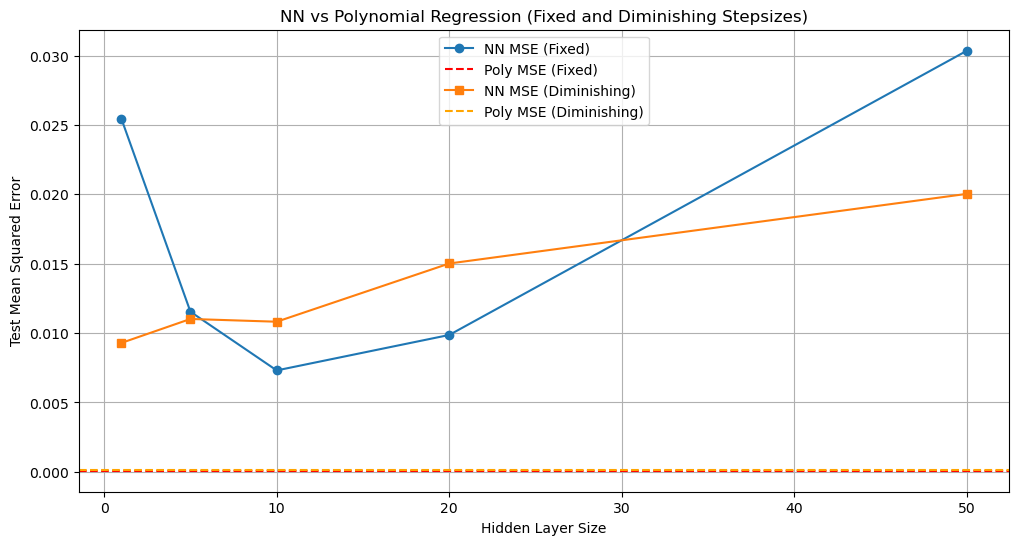

In [85]:
plt.figure(figsize=(12, 6))

# Fixed
plt.plot(hidden_sizes, nn_test_mse_fixed, marker='o', label='NN MSE (Fixed)')
plt.axhline(poly_mse_fixed, color='r', linestyle='--', label='Poly MSE (Fixed)')

# Diminishing
plt.plot(hidden_sizes, nn_test_mse_diminish, marker='s', label='NN MSE (Diminishing)')
plt.axhline(poly_mse_diminish, color='orange', linestyle='--', label='Poly MSE (Diminishing)')

plt.xlabel('Hidden Layer Size')
plt.ylabel('Test Mean Squared Error')
plt.title('NN vs Polynomial Regression (Fixed and Diminishing Stepsizes)')
plt.legend()
plt.grid(True)
plt.show()


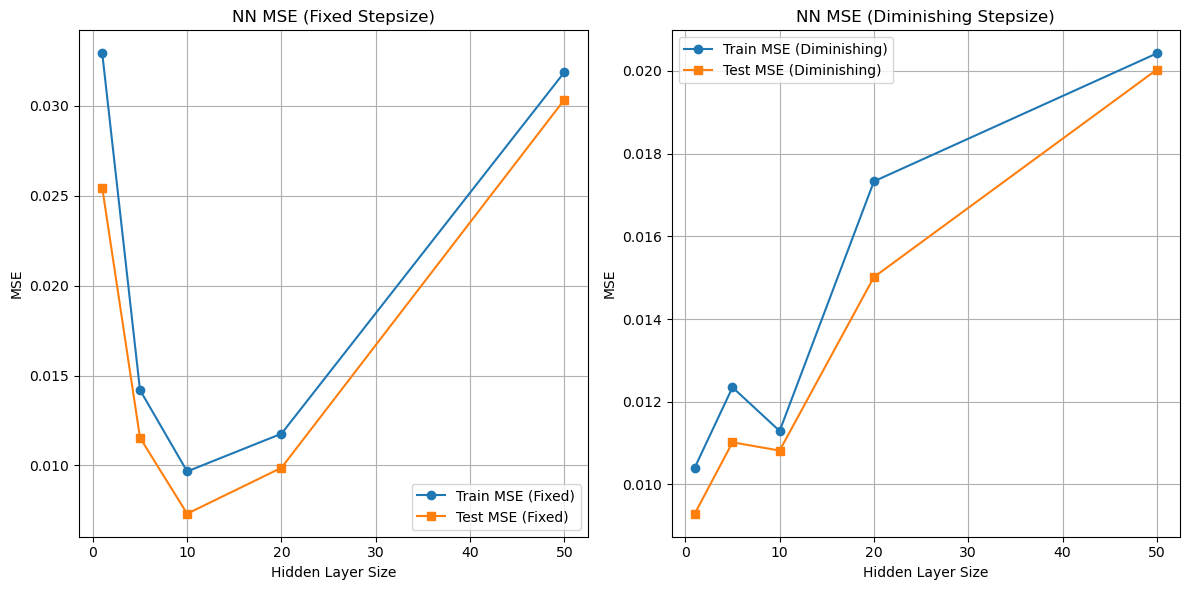

In [86]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hidden_sizes, nn_train_mse_fixed, marker='o', label='Train MSE (Fixed)')
plt.plot(hidden_sizes, nn_test_mse_fixed, marker='s', label='Test MSE (Fixed)')
plt.xlabel('Hidden Layer Size')
plt.ylabel('MSE')
plt.title('NN MSE (Fixed Stepsize)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hidden_sizes, nn_train_mse_diminish, marker='o', label='Train MSE (Diminishing)')
plt.plot(hidden_sizes, nn_test_mse_diminish, marker='s', label='Test MSE (Diminishing)')
plt.xlabel('Hidden Layer Size')
plt.ylabel('MSE')
plt.title('NN MSE (Diminishing Stepsize)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
